Tabla guardada en subjects_roi_timepoints_stats.csv

Resumen N_timepoints:
count     352.0
mean     1000.0
std         0.0
min      1000.0
25%      1000.0
50%      1000.0
75%      1000.0
max      1000.0
Name: N_timepoints, dtype: float64

Resumen N_ROIs:
count    352.000000
mean     180.252841
std       26.479606
min      140.000000
25%      140.000000
50%      197.000000
75%      197.000000
max      200.000000
Name: N_ROIs, dtype: float64


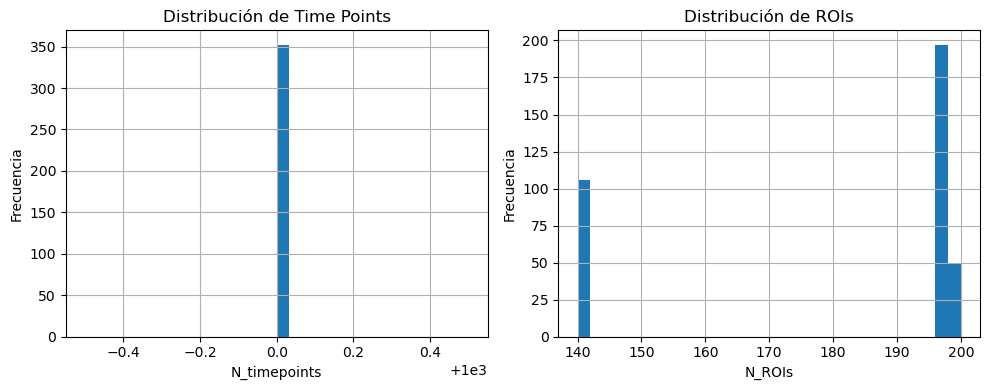

In [7]:
import os
import pandas as pd
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt

# ==== CONFIGURACIÓN ====
subject_csv = '/home/diego/Escritorio/Schaefer_1000/DataBaseSubjects.csv'
roi_signals_dir = '/home/diego/Escritorio/Schaefer_1000/ROISignals'
roi_filename_template = 'ROISignals_{subject_id}.mat'
output_csv = 'subjects_roi_timepoints_stats.csv'

# ==== LEER LISTA DE SUJETOS ====
subjects_df = pd.read_csv(subject_csv)
subjects_df['SubjectID'] = subjects_df['SubjectID'].astype(str).str.strip()
subject_ids = subjects_df['SubjectID'].tolist()

# ==== RECORRER CADA SUJETO Y LEER .mat ====
results = []

for sid in subject_ids:
    mat_path = Path(roi_signals_dir) / roi_filename_template.format(subject_id=sid)
    if not mat_path.exists():
        print(f'[WARN] No encontrado: {mat_path}')
        continue
    try:
        data = sio.loadmat(mat_path)
        loaded_sigs = data.get("ROISignals", data.get("signals", data.get("roi_signals", data.get("ROIsignals")))
        )
        if loaded_sigs is None:
            print(f'[WARN] No señales en: {mat_path}')
            continue
        # Forzar matriz 2D
        if loaded_sigs.ndim == 1:
            loaded_sigs = loaded_sigs[:, np.newaxis]
        if loaded_sigs.shape[0] < loaded_sigs.shape[1] and loaded_sigs.shape[0] > 1:
            loaded_sigs = loaded_sigs.T
        T, N = loaded_sigs.shape
        results.append({'SubjectID': sid, 'N_timepoints': T, 'N_ROIs': N, 'mat_path': str(mat_path)})
    except Exception as e:
        print(f'[ERROR] {sid}: {e}')

# ==== CREAR DATAFRAME Y GUARDAR ====
res_df = pd.DataFrame(results)
res_df.to_csv(output_csv, index=False)
print(f'Tabla guardada en {output_csv}')

# ==== ESTADÍSTICA BÁSICA E HISTOGRAMAS ====
if not res_df.empty:
    print('\nResumen N_timepoints:')
    print(res_df['N_timepoints'].describe())
    print('\nResumen N_ROIs:')
    print(res_df['N_ROIs'].describe())

    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    res_df['N_timepoints'].hist(bins=30)
    plt.title('Distribución de Time Points')
    plt.xlabel('N_timepoints')
    plt.ylabel('Frecuencia')
    plt.subplot(1,2,2)
    res_df['N_ROIs'].hist(bins=30)
    plt.title('Distribución de ROIs')
    plt.xlabel('N_ROIs')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
else:
    print('No se encontraron datos para graficar.')

In [8]:
# Extract the top 3 N_timepoints from the histogram plot
top_3_timepoints = res_df['N_timepoints'].value_counts().head(3).index.tolist()
top_3_timepoints

[1000]

In [9]:
# Obtener conteos de los tres más frecuentes
top3_counts = res_df['N_timepoints'].value_counts().loc[top_3_timepoints]
print(top3_counts)


N_timepoints
1000    352
Name: count, dtype: int64


In [10]:
from pathlib import Path

# Suponiendo que ya tienes tu DataFrame res_df con la columna 'mat_path'
output_txt = 'subjects_roi_stats.txt'

with open(output_txt, 'w') as f:
    # Cabecera
    f.write('filename\tN_timepoints\tN_ROIs\n')
    # Filas
    for _, row in res_df.iterrows():
        filename = Path(row['mat_path']).name
        f.write(f"{filename}\t{row['N_timepoints']}\t{row['N_ROIs']}\n")

print(f"Archivo guardado en: {output_txt}")
# Mostrar los primeros 5 registros del DataFrame
print(res_df.head())

Archivo guardado en: subjects_roi_stats.txt
    SubjectID  N_timepoints  N_ROIs  \
0  002_S_0295          1000     140   
1  002_S_0413          1000     140   
2  002_S_0685          1000     140   
3  002_S_0729          1000     140   
4  002_S_1155          1000     197   

                                            mat_path  
0  /home/diego/Escritorio/Schaefer_1000/ROISignal...  
1  /home/diego/Escritorio/Schaefer_1000/ROISignal...  
2  /home/diego/Escritorio/Schaefer_1000/ROISignal...  
3  /home/diego/Escritorio/Schaefer_1000/ROISignal...  
4  /home/diego/Escritorio/Schaefer_1000/ROISignal...  


In [11]:
# Conteo de todas las ocurrencias por valor de N_ROIs
counts = res_df['N_ROIs'].value_counts()

print("Distribución de N_ROIs:")
print(counts)

# Si sólo te interesan 140 y 170:
n_140 = counts.get(140, 0)
n_197 = counts.get(197, 0)
n_200 = counts.get(200, 0)

print(f"\nSujetos con 140 ROIs: {n_140}")
print(f"Sujetos con 170 ROIs: {n_197}")
print(f"Sujetos con 200 ROIs: {n_200}")

# Comprobar si hay otros valores distintos
otros = counts.drop([140, 197, 200], errors='ignore')
if not otros.empty:
    print("\nOtros valores de ROIs presentes:")
    print(otros)
else:
    print("\nNo hay otros valores de ROIs distintos de 140 y 170.")


Distribución de N_ROIs:
N_ROIs
197    197
140    106
200     49
Name: count, dtype: int64

Sujetos con 140 ROIs: 106
Sujetos con 170 ROIs: 197
Sujetos con 200 ROIs: 49

No hay otros valores de ROIs distintos de 140 y 170.
